<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/MNIST_CNN_STUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

inputs = torch.Tensor(1,1,28,28)

conv1 = nn.Conv2d(1,32,3,padding=1)
conv2 = nn.Conv2d(32,64,kernel_size = 3,padding=1)
pool = nn.MaxPool2d(2)
fc = nn.Linear(3136,10)
out = conv1(inputs)
out = pool(out)
out = conv2(out)
out = pool(out)

out = out.view(out.size(0),-1)
out = fc(out)

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.manual_seed(777)

if device == 'cuda' :
  torch.cuda.manual_seed_all(777)

cuda


In [4]:
lr = 0.0001
epochs = 50
batch_size = 100

mnist_train = dsets.MNIST(root = 'MNIST_data', train = True, transform = transforms.ToTensor(),download=True)
mnist_test = dsets.MNIST(root = 'MNIST_data', train = False, transform = transforms.ToTensor(),download=True)
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,batch_size = batch_size,shuffle = True,drop_last = True)



In [40]:
x,y = mnist_train[0]

print(x.shape)

torch.Size([1, 28, 28])


In [33]:
class CNN(torch.nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.keep_prob = 0.5
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32,64,kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = torch.nn.Sequential(
        torch.nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
    )
    self.fc1 = torch.nn.Linear(4*4*128,625,bias=True)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.layer4 = torch.nn.Sequential(
        self.fc1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1-self.keep_prob)
    )
    self.fc2 = torch.nn.Linear(625,10,bias = True)
    torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self, x) :
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0),-1)
    out = self.layer4(out)
    out = self.fc2(out)
    return out

In [41]:
class AlexNet(nn.Module) :
    def __init__(self) -> None :
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),)
        
    def forward(self, x :torch.Tensor) -> torch.Tensor :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [42]:
#model = CNN().to(device)
model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [43]:
from torchsummary import summary

summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 192, 14, 14]         110,784
              ReLU-5          [-1, 192, 14, 14]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

In [44]:
for epoch in range(epochs) :
  avg_cost = 0

  for X,Y in data_loader :
    X = X.to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis,Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost/len(data_loader)
  
  print('[Epoch: {:>4} cost = {:>.9}'.format(epoch+1,avg_cost))

[Epoch:    1 cost = 0.315992147
[Epoch:    2 cost = 0.0694760531
[Epoch:    3 cost = 0.0495758839
[Epoch:    4 cost = 0.0382314399
[Epoch:    5 cost = 0.0307157524
[Epoch:    6 cost = 0.0247671884
[Epoch:    7 cost = 0.0228599478
[Epoch:    8 cost = 0.0184384622
[Epoch:    9 cost = 0.0149625847
[Epoch:   10 cost = 0.0153318401
[Epoch:   11 cost = 0.0137417205
[Epoch:   12 cost = 0.0114611713
[Epoch:   13 cost = 0.0106107723
[Epoch:   14 cost = 0.00952898711
[Epoch:   15 cost = 0.00762051623
[Epoch:   16 cost = 0.008436542
[Epoch:   17 cost = 0.00720271422
[Epoch:   18 cost = 0.00822198018
[Epoch:   19 cost = 0.00618436141
[Epoch:   20 cost = 0.00571927195
[Epoch:   21 cost = 0.00667660171
[Epoch:   22 cost = 0.00615458982
[Epoch:   23 cost = 0.00445455639
[Epoch:   24 cost = 0.00470802328
[Epoch:   25 cost = 0.00435771095
[Epoch:   26 cost = 0.00444895914
[Epoch:   27 cost = 0.00575901289
[Epoch:   28 cost = 0.00272086449
[Epoch:   29 cost = 0.00345087447
[Epoch:   30 cost = 0.00518601

In [48]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy: {:.2f} %'.format(accuracy.item()*100))

Accuracy: 98.98 %


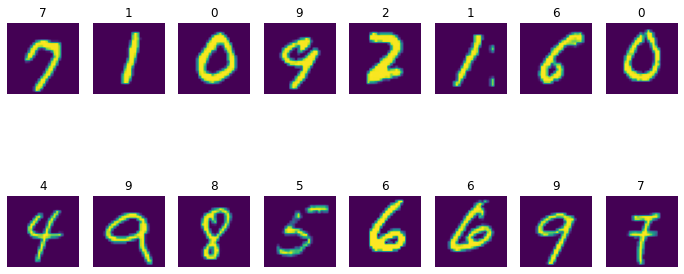

In [73]:
import matplotlib.pyplot as plt
import numpy as np
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size,shuffle=True)
samples, labels = next(iter(test_loader))

figure = plt.figure(figsize = (12,12))

for i in range(16) :
  sample = np.squeeze(samples[i])
  a = figure.add_subplot(2,8,i+1)
  a.set_title(int(labels[i]))
  a.axis('off')
  a.imshow(sample.numpy())

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)